### Hello!
This is a schedule creator for my colleagues. We work as a team of 8 (maximum). This schedule is to provide ample coverage for our help desk, so that enough representatives are available at each time for our clients. I was unable to find a package or software that worked for the unique needs of our team, so created this with a colleague of mine. 

We refer to taking live help desk tickets as being "on ADD" and when we are working on other duties we are "off ADD" which you will see below. This schedule accomodates for 8 of us, and works with partial days, our colleagues being out, or a "custom" shift if a specific team member has a unique schedule.

The cell below is the only cell that needs to be updated with the users path.

In [9]:
#setting path to users path - updating sheet if necessary
path = r"C:\Users\celes\OneDrive\Documents\Schedule_1.xlsx"
sheet = 'SHIFT'

In [10]:
#importing necessary libraries
from datetime import date 
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [11]:
# set up, reading in excel file into data frame
# each day has a different data frame in order to show the schedule for each day
df = pd.read_excel(path, sheet_name=sheet, header = 0)

monday_df = df.loc[(df['weekday'] == 'Monday') ]
tuesday_df =  df.loc[(df['weekday'] == 'Tuesday') ]
wednesday_df =  df.loc[(df['weekday'] == 'Wednesday') ]
thursday_df =  df.loc[(df['weekday'] == 'Thursday') ]
friday_df =  df.loc[(df['weekday'] == 'Friday') ]

In [12]:
#define class CW with variables from excel (A CW represents one person from the team and their schedule / characteristics)
class CW:
    def __init__(self, name, rp, start_time, end_time, break_time, lunch_time, 
                 lunch_pd, break_pd, shift, weekday):
        self.name = name
        self.rp = rp
        self.start_time = start_time
        self.end_time = end_time
        self.break_time = break_time
        self.lunch_time = lunch_time
        self.lunch_pd = lunch_pd
        self.break_pd = break_pd
        self.shift = shift #early, mid, late, partial day, out
        self.weekday = weekday #day of the week
        
    def __eq__(self, other):
        return self.start_time == other.start_time and self.end_time == other.end_time

    def __lt__(self, other):
        if self.end_time == other.end_time:
            if self.start_time == other.start_time:
                return self.name < other.name
            else: return self.start_time < other.start_time
        else: return self.end_time < other.end_time

In [13]:
#helper functions 
    #changes float military time integer to index for schedule ex: 8 (8:00AM) to index 0
def time_to_index(time):
    index = (float(time) - 8)*4
    return int(index)
    #changes index to float military time integer for schedule ex: index 0 to 8 (8:00AM)
def index_to_time(index):
    time = 8 + index/4
    return time
    #returns military integer to string for readability
def military_to_str_time(military):
    hour = math.floor(military) 
    minute = int((military % 1) * 60)
    if (minute == 0):
        minute = "00"
    return str(hour)+ ":" + str(minute)

In [14]:
#With shift == OUT, sets values in schedule as out
def is_out(CW_arr, person, schedule):
    if CW_arr[person].shift == 'OUT':
        x = 0
        for col in schedule[person]:
            schedule[person][x] = 3
            x += 1
        return True
    else:
        return False

# Set as OUT to times before and after start/end time 
def set_out_codes(schedule, CW_arr):
    person = 0
    for person in range(len(CW_arr)):
        if is_out(CW_arr, person, schedule) == True:
            continue 
        else:
            if int(CW_arr[person].start_time) > 8:
                s = time_to_index(CW_arr[person].start_time) - 1             
                while s >= 0:
                    schedule[person][s] = 3
                    s -= 1
            if int(CW_arr[person].end_time) < 18:
                e = time_to_index(CW_arr[person].end_time) 
                while e != time_to_index(18):
                    schedule[person][e] = 3
                    e += 1
# Set on add periods according to lunch_pd and break_pd with break_time and lunch_time               
def set_on_add(schedule, CW_arr):
    for i in range(len(schedule)):
            for j in range(len(schedule[0])):
                if schedule[i][j] == 0:
                    schedule[i][j] = 1
    person = 0
    for person in range(len(CW_arr)):
        if is_out(CW_arr, person, schedule) == True:
            continue
        else:
            #set lunch time to OFF ADD
            l = time_to_index(CW_arr[person].lunch_time)
            lb = l + (CW_arr[person].lunch_pd * 4)
            while l< lb and lb < len(schedule[person]):
                schedule[person][l] = 0
                l+=1
            #set break time to OFF ADD    
            b = time_to_index(CW_arr[person].break_time)
            bb = b + (CW_arr[person].break_pd * 4)
            while b < bb and bb < len(schedule[person]):
                schedule[person][b] = 0
                b+=1
            #set 15 minutes before end_time to OFF ADD
            schedule[person][time_to_index(CW_arr[person].end_time)-1] = 0
            


In [15]:
#returns an array similar to total_rep_pwr_needed where each index is a 15 minute slot, the value for the index is the number of reps on add
def total_rep_power(CW_arr, schedule, total_rep_pwr_needed):
    total_reps_arr = []
    for time in range(len(schedule[0])):
        reps_on_add = 0
        for person in range(len(schedule)):
            if schedule[person][time] == 1:
                reps_on_add += 1
        total_reps_arr.append(reps_on_add)
    return total_reps_arr

In [16]:
#if enough reps are on add at an index time, for each index time, no updates are needed and the schedule "is optimized"
def is_optimized(schedule, CW_arr, total_rep_pwr_needed):
    total_rep_pwr = total_rep_power(CW_arr, schedule, total_rep_pwr_needed)
    for i in range(len(total_rep_pwr_needed) - 1):
        if (total_rep_pwr_needed[i] > total_rep_pwr[i]):
            return False
    return True 
#helper function to format schedule if the schedule is not optimized
def choose_overlap(group):
    time_index = 0
    lunch_overlap = 0
    break_overlap = 0
    move_break_by = 0
    
    if len(group) == 2: 
        time_index = 4 
        lunch_overlap = 6 
        break_overlap = 6
        move_break_by = 2
        
    if len(group) == 3:
        time_index = 4
        lunch_overlap = 4
        break_overlap = 4
        move_break_by = 2
        
    if len(group) == 4:
        time_index = 6
        lunch_overlap = 3
        break_overlap = 3
        move_break_by = 2
    
    if len(group) == 5:
        time_index = 5
        lunch_overlap = 2
        break_overlap = 2
        move_break_by = 4
        
    if len(group) == 6:
        time_index = 5
        lunch_overlap = 2
        break_overlap = 2
        move_break_by = 2
        
    if len(group) == 7: #4220
        time_index = 2
        lunch_overlap = 2
        break_overlap = 2
        move_break_by = 1 #1
    
    if len(group) == 8:
        time_index = 0
        lunch_overlap = 2
        break_overlap = 2
        move_break_by = -1
    
    return time_index, lunch_overlap, break_overlap, move_break_by



In [17]:
#this function uses choose_overlap to format the schedule so each rep will go on break in order
def create_cascade(schedule, CW_arr, group):
    time_index, lunch_overlap, break_overlap, move_break_by = choose_overlap(group)

    for i in range(len(group)):
        CW_arr[group[i]].lunch_time = index_to_time(time_index)
        time_index += lunch_overlap
        
    time_index += move_break_by
    for j in range(len(group)):
        CW_arr[group[j]].break_time = index_to_time(time_index)
        time_index += break_overlap    

#this function will choose adequate break times based on hour many hours a rep is working, 
# so that in the case of a shorter day, they are on add a proportionate amount to their colleagues
def partial_day(CW_arr, person):
    start =  CW_arr[person].start_time 
    end = CW_arr[person].end_time
    if end - start < 6: #shorter than 5 hours
        #only get lunch, no break
        CW_arr[person].break_pd = 0
        CW_arr[person].lunch_pd = math.floor((CW_arr[person].end_time - CW_arr[person].start_time)*(3/8)*4)/4 
        CW_arr[person].lunch_time = start + ((end-start)/2) - math.floor(CW_arr[person].lunch_pd*2)/4
      
    else: #longer than five hours
        CW_arr[person].lunch_pd = math.ceil((CW_arr[person].end_time - CW_arr[person].start_time)*(3/8)*2)/4
        CW_arr[person].break_pd = math.floor((CW_arr[person].end_time - CW_arr[person].start_time)*(3/8)*2)/4
        move = (math.floor((end-start)*2/3)/4)
        
        CW_arr[person].lunch_time = start+move
        CW_arr[person].break_time = start+CW_arr[person].lunch_pd+move*3
        #lunch and break
    

In [18]:
#create initial matrix that represents the schedule
def initialize_schedule(df): 
    total_rep_pwr_needed = [3] * int((9.5-8)*4) + [4] * int((16.25-9.5)*4) + ([2] * int((18-16.25)*4))
    todays_CW_arr = [CW(a.name, a.rp, a.start_time, a.end_time, a.break_time, a.lunch_time, 
                 a.lunch_pd, a.break_pd, a.shift, a.weekday) for a in df.itertuples()]
    todays_schedule = [[1 for x in range((18-8)*4)] for y in range(len(todays_CW_arr))]
    todays_CW_arr.sort()
    set_out_codes(todays_schedule, todays_CW_arr)
    set_on_add(todays_schedule, todays_CW_arr)
    return todays_schedule, todays_CW_arr, total_rep_pwr_needed
#optimize the matrix
def optimize_schedule(schedule, CW_arr, total_rep_pwr_needed):
    optimized = is_optimized(schedule, CW_arr, total_rep_pwr_needed)
    if optimized:
        return schedule
    else:
        group = []
        for i in range(len(CW_arr)):
            if CW_arr[i].shift == 'EARLY' or CW_arr[i].shift == 'MID' or CW_arr[i].shift == 'LATE':
                group.append(i)
            elif CW_arr[i].shift == 'PARTIAL':
                partial_day(CW_arr, i)
        if len(group) > 1:
            create_cascade(schedule, CW_arr, group)
        set_on_add(schedule, CW_arr)
        set_out_codes(schedule, CW_arr)
    

In [19]:
#choose different colors for each month (holiday related) for fun!
todays_date = date.today() 
month_colors = [0 for i in range(13)]
month_colors[1] = ['teal', 'powderblue', 'darkslateblue'] #january
month_colors[2] = ['palevioletred', 'lightpink', 'mediumvioletred'] #february
month_colors[3] = ['mediumseagreen', 'palegreen', 'darkgreen'] #march #out black
month_colors[4] = ['lightcoral', 'lightgreen', 'cornflowerblue'] #april
month_colors[5] = ['palevioletred', 'lightpink', 'olivedrab'] #may
month_colors[6] = ['#ff4500', 'lightsalmon', 'rebeccapurple'] #june
month_colors[7] = ['steelblue', 'lightblue', 'firebrick']#july
month_colors[8] = ['palevioletred', 'yellowgreen', 'rebeccapurple']#august
month_colors[9] = ['tomato', 'yellowgreen', 'cadetblue']
month_colors[10] = ['darkorange', 'greenyellow', 'rebeccapurple'] #october
month_colors[11] = ['orangered', 'gold', 'saddlebrown'] #november
month_colors[12] = ['#9d2933', '#b3bb8d', '#0a4d53'] #december
colors = month_colors[todays_date.month]

In [20]:
#create a readable schedule, and download them as images
def visualize_schedule(schedule, CW_arr, weekday_str):
    shifts = [0, 1, 3]
    shiftslabels = ['OFF', 'ON', 'OUT']
    #plt.rcParams["figure.figsize"] = (10,8)
    y_text_dict = []
    for i in range(len(CW_arr)):
        y_text_dict.append(CW_arr[i].name)
    x_text_dict = []
    for i in range(len(schedule[0])):
        x_text_dict.append(military_to_str_time(index_to_time(i)))
    fig, ax = plt.subplots(figsize=(20,15))
    cmap = plt.cm.colors.ListedColormap(colors)
    ax.imshow([[shifts.index(shift) for shift in day] for day in schedule], cmap = cmap)
    xtick =[]
    for i in range(len(schedule[0])):
        xtick.append(i - .5)
    ax.set_xticks(xtick)
    ax.set_xticklabels(x_text_dict)
    ax.set_yticks(range(len(y_text_dict)))
    ax.set_yticklabels(y_text_dict)
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='solid')
    legend_labels = [plt.Rectangle((0,0),1,1, color=colors[i], label=shifts[i]) for i in range(len(shifts))]
    ax.legend(legend_labels, shiftslabels, loc="upper left")
    plt.xlim([0, 39])
    plt.tight_layout()
    plt.title(weekday_str)
    plt.savefig(weekday_str+'_schedule.png',dpi = 199, bbox_inches='tight')
    plt.show()

In [21]:
def weekday_schedule(weekday_df, weekday_str):
    todays_schedule, todays_CW_arr, total_rep_pwr_needed = initialize_schedule(weekday_df)
    optimize_schedule(todays_schedule, todays_CW_arr, total_rep_pwr_needed)
    visualize_schedule(todays_schedule, todays_CW_arr, weekday_str)

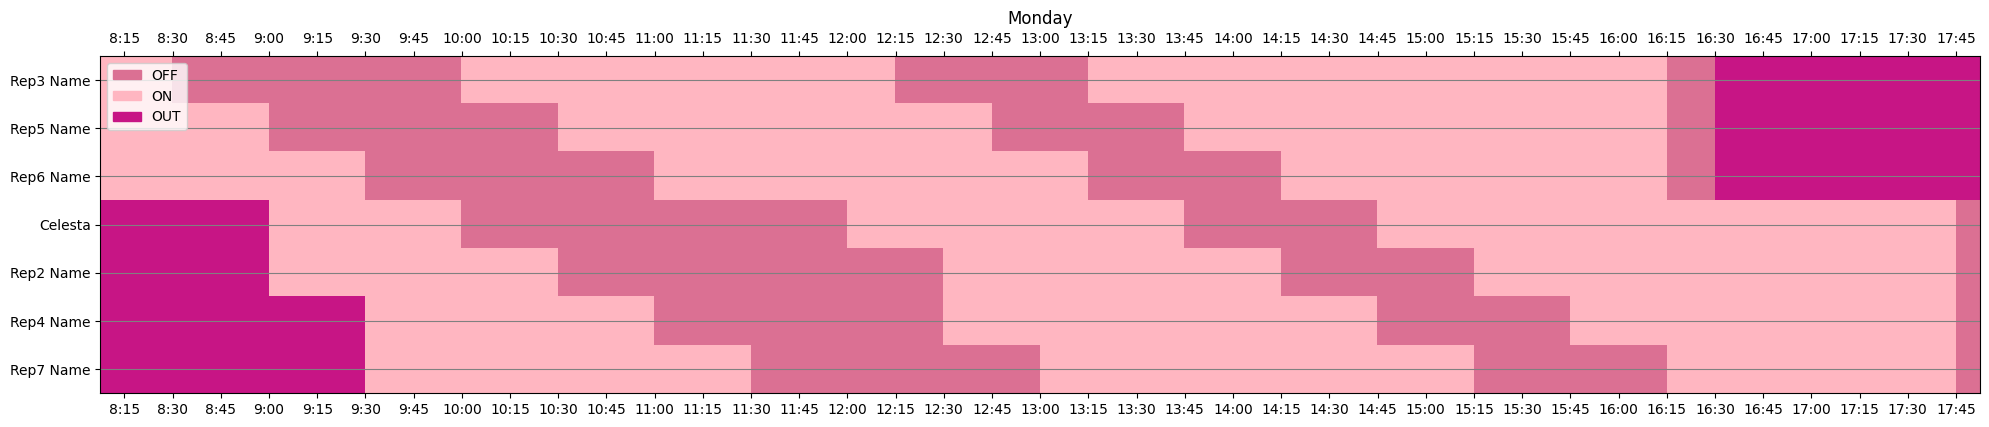

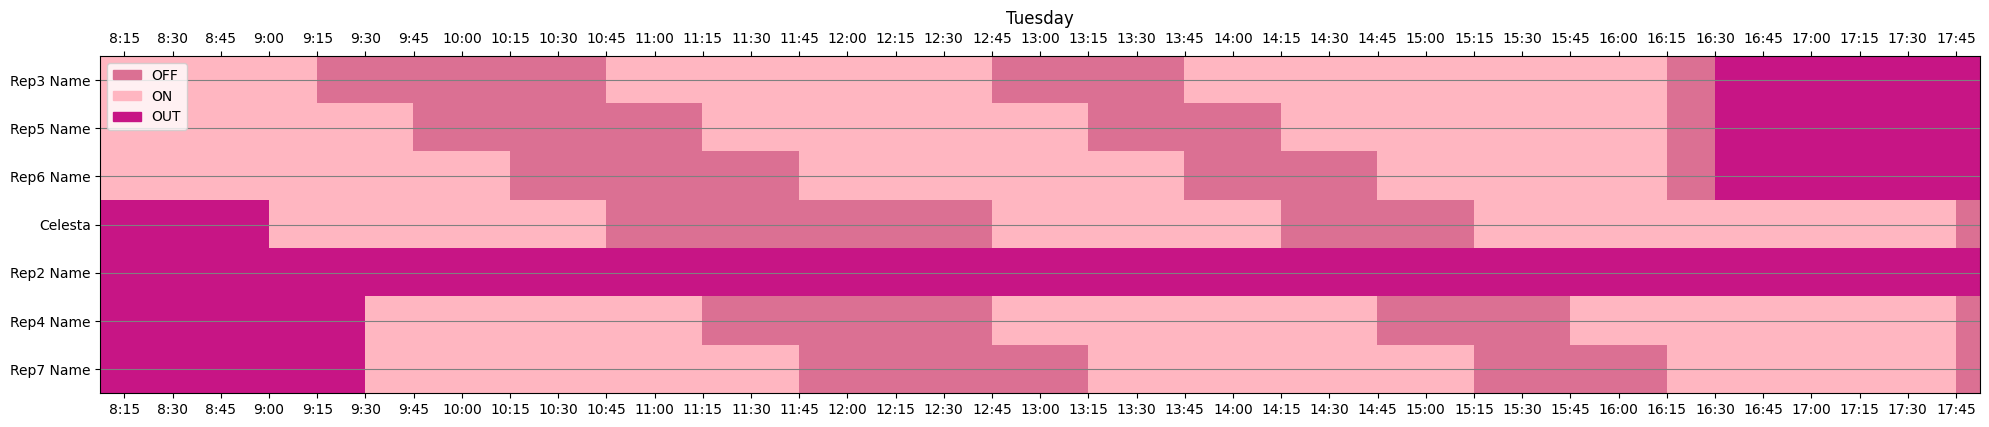

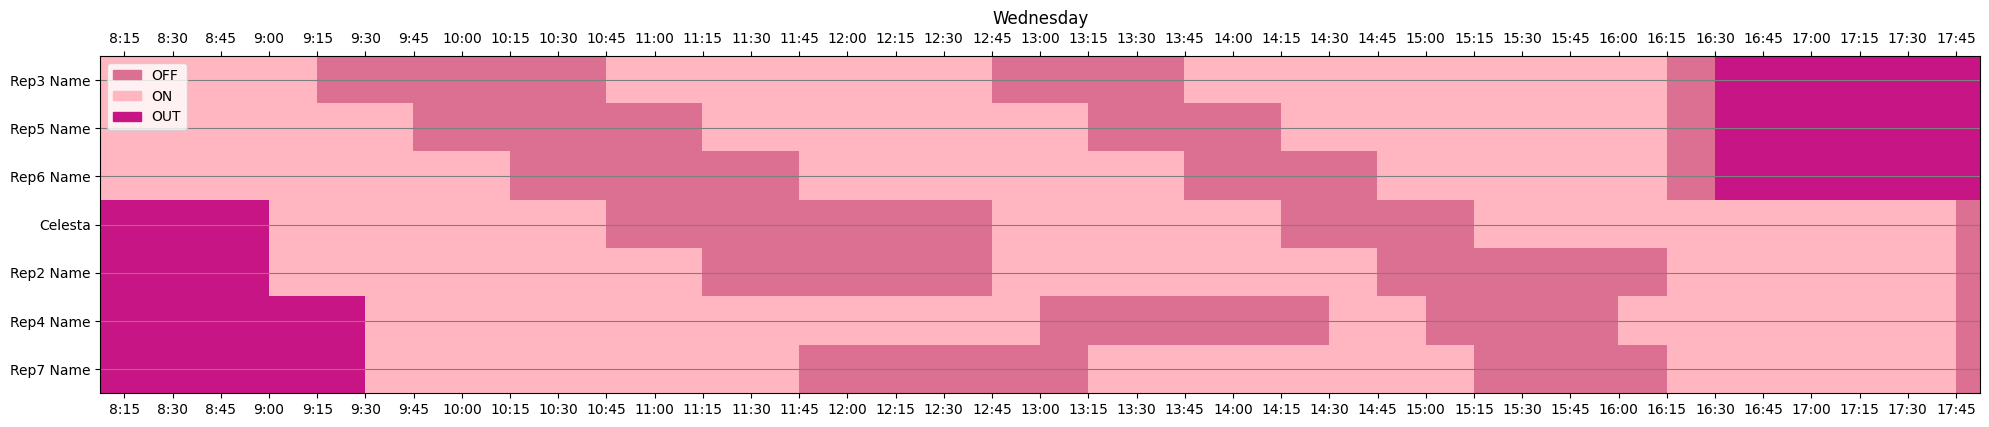

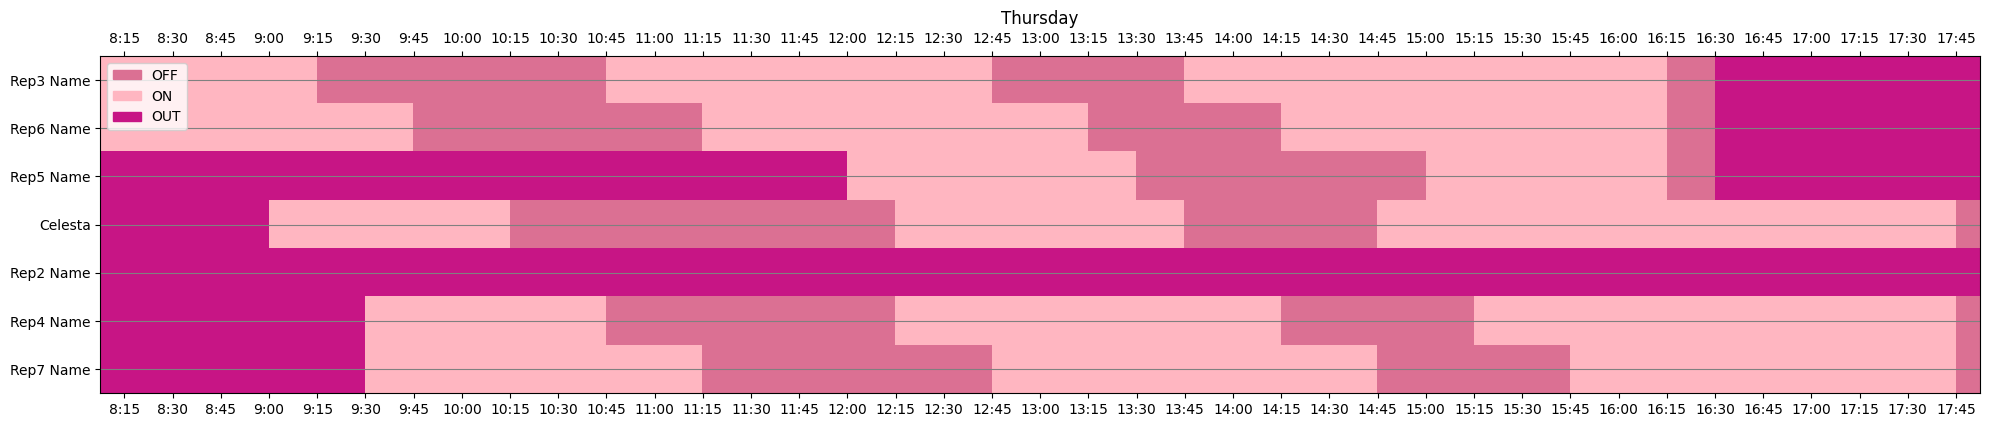

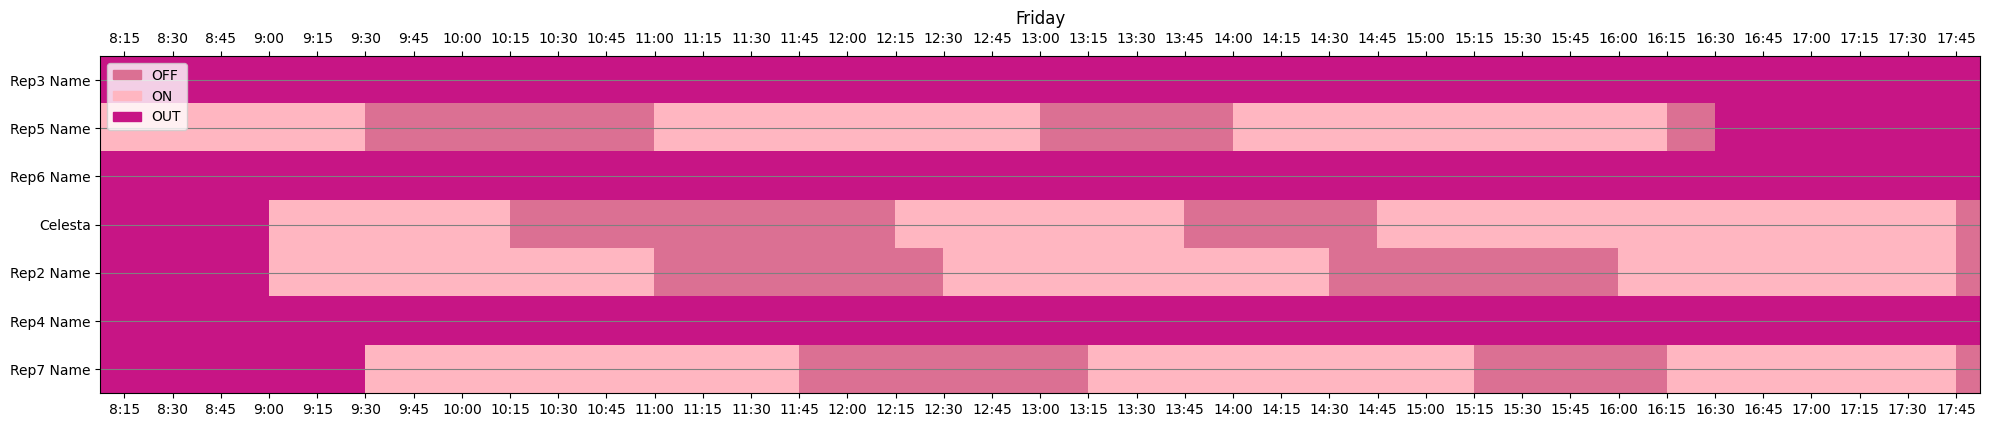

In [22]:
weekday_schedule(monday_df, "Monday")
weekday_schedule(tuesday_df, "Tuesday")
weekday_schedule(wednesday_df, "Wednesday")
weekday_schedule(thursday_df, "Thursday")
weekday_schedule(friday_df, "Friday")